In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

path = Path("C:/Users/hhars/Downloads/archive (2)/UTKFace/")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels

gender_dict = {0: "Male", 1: "Female"}
df = df.astype({'age':'float32', 'gender': 'int32'})


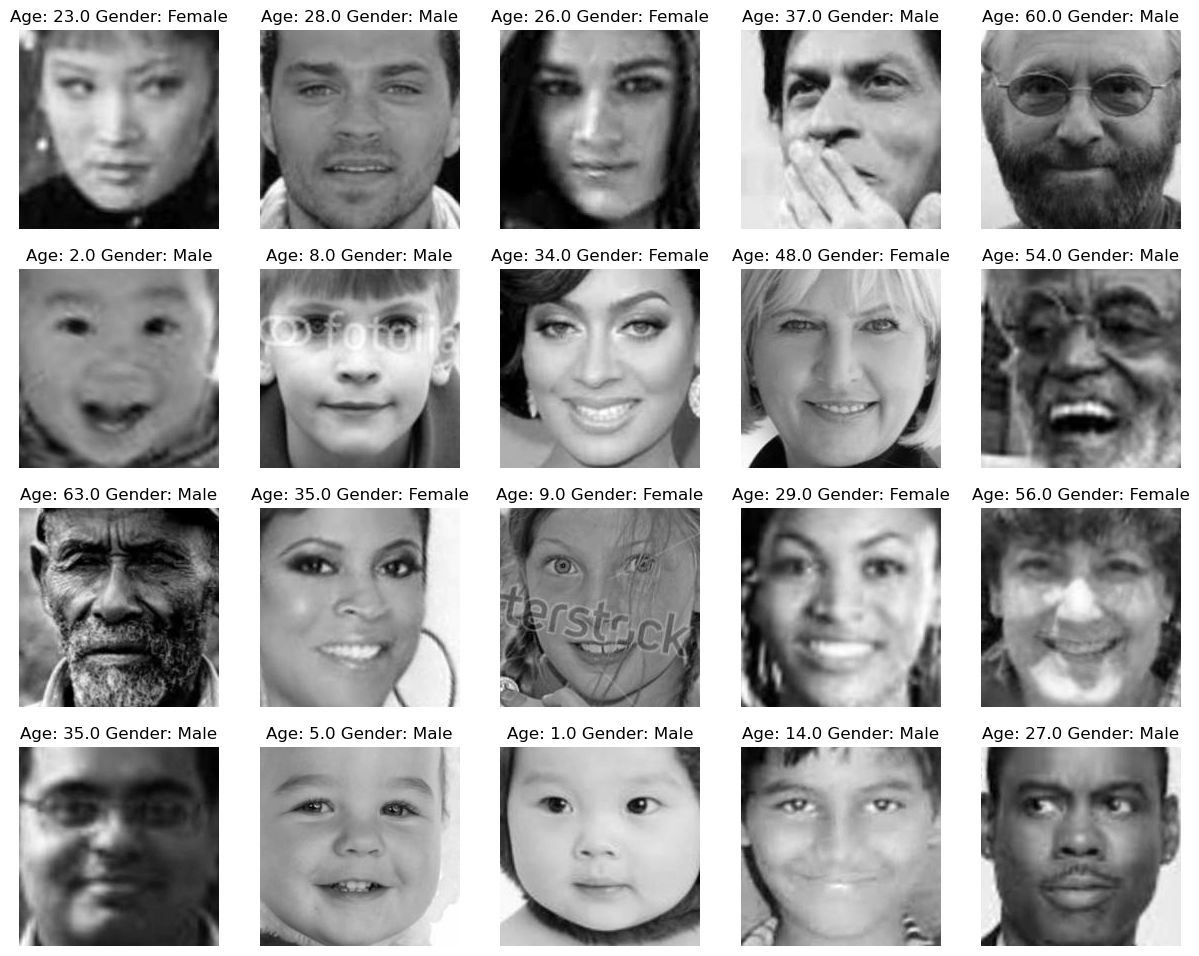

In [12]:
# Cell 2: Visualizing Images (Optional)
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("C:/Users/hhars/Downloads/archive (2)/UTKFace/"+file, color_mode='grayscale')
    img = np.array(img)
    plt.imshow(img, cmap='gray')  # Add cmap='gray' to display grayscale images
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')


In [13]:
train, test = train_test_split(df, test_size=0.85, random_state=42)

In [15]:
# Cell 4: Extracting Features
x_train = []
for file in train.image:
    img = load_img("C:/Users/hhars/Downloads/archive (2)/UTKFace/"+file, color_mode='grayscale')
    img = img.resize((128,128), Image.LANCZOS)  # Use LANCZOS filter for resizing
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)
x_train = x_train.reshape(len(x_train), 128, 128, 1)
x_train = x_train/255

y_gender = np.array(train.gender)
y_age = np.array(train.age)
input_size = (128, 128, 1)


In [18]:
# Cell 5: Creating the Model
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 126, 126, 64)         640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 126, 126, 64)         256       ['conv2d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 42, 42, 64)           0         ['batch_normalization_1[0]

In [19]:
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size=10, epochs=20, validation_split=0.1)

Epoch 1/20
320/320 [==============================] - 208s 640ms/step - loss: 16.5316 - gender_output_loss: 0.6604 - age_output_loss: 15.8712 - gender_output_accuracy: 0.6744 - age_output_accuracy: 0.0469 - val_loss: 25.5657 - val_gender_output_loss: 0.6448 - val_age_output_loss: 24.9210 - val_gender_output_accuracy: 0.7191 - val_age_output_accuracy: 0.0506
Epoch 2/20
320/320 [==============================] - 198s 619ms/step - loss: 12.9381 - gender_output_loss: 0.5013 - age_output_loss: 12.4368 - gender_output_accuracy: 0.7578 - age_output_accuracy: 0.0284 - val_loss: 11.8534 - val_gender_output_loss: 0.5275 - val_age_output_loss: 11.3259 - val_gender_output_accuracy: 0.7472 - val_age_output_accuracy: 0.0506
Epoch 3/20
320/320 [==============================] - 202s 630ms/step - loss: 11.3097 - gender_output_loss: 0.4159 - age_output_loss: 10.8938 - gender_output_accuracy: 0.8056 - age_output_accuracy: 0.0188 - val_loss: 12.2926 - val_gender_output_loss: 0.4577 - val_age_output_loss:

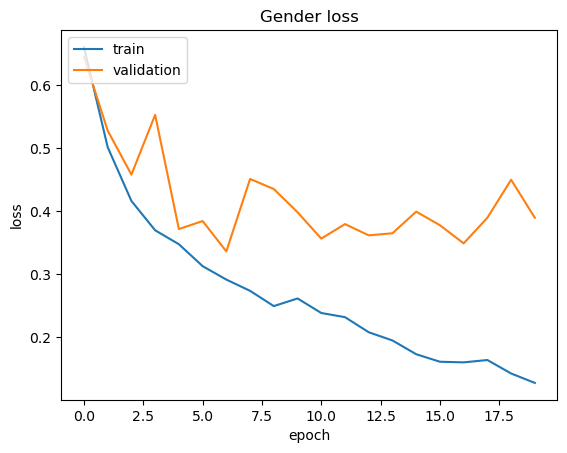

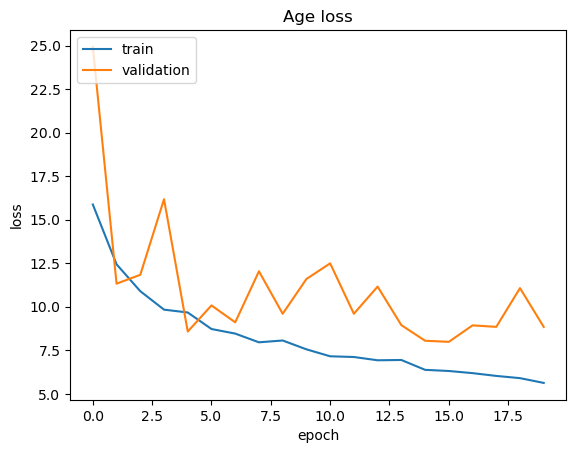

In [20]:
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Original: Gender = Male Age = 35.0
1/1 [==============================] - 0s 266ms/step
Prediction: Gender = Male Age = 31


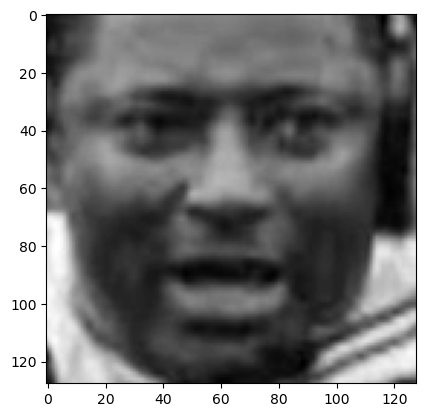

In [21]:
index = 50
print("Original: Gender =", gender_dict[y_gender[index]], "Age =", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])] 
pred_age = round(pred[1][0][0])

print("Prediction: Gender =", pred_gender, "Age =", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')


In [2]:
# Load and preprocess the input image
input_image_path = "C:\Users\hhars\Downloads\archive (2)\UTKFace\1_0_0_20161219140623097.jpg"
input_img = load_img(C:\Users\hhars\Downloads\archive (2)\UTKFace\1_0_0_20161219140623097.jpg, color_mode='grayscale')
input_img = input_img.resize((128, 128), Image.LANCZOS)
input_img = np.array(input_img)
input_img = input_img.reshape(1, 128, 128, 1) / 255.0

# Predict the age and gender
pred_gender, pred_age = model.predict(input_img)
pred_gender = gender_dict[round(pred_gender[0][0])]
pred_age = round(pred_age[0][0])

# Display the results
print("Predicted Gender:", pred_gender)
print("Predicted Age:", pred_age)

# Display the input image
plt.imshow(input_img[0].reshape(128, 128), cmap='gray')


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (4247567969.py, line 2)